In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### the following function extracts the standardized coefficients from a statsmodels-model
#### the returned coefficients can be used in the same way as the coefficents extracted from the scikit model (see below)

In [12]:
def get_standardized_coefficients(statsmodelsfile, log_betas = False):
    print(statsmodelsfile.summary())

    std = statsmodelsfile.model.exog.std(0)

    std_y = statsmodelsfile.model.endog.std(0) 
    tt = statsmodelsfile.t_test(np.diag(std / std_y))

    standardized_df = tt.summary_frame()
    standardized_df.rename(columns={'coef':'beta'},inplace=True)
    standardized_df.index = statsmodelsfile.model.exog_names
    print("standardized coefficients")
    print(standardized_df)

    betas = standardized_df["beta"]

    if log_betas == False:
        return betas
    else:
        print("log standardized coefficients")
        log_betas = np.log(np.abs(betas))
        return log_betas

#### loading of example scikit files

In [13]:
#scikit logistic regression model
example_file = pd.read_pickle("archie_50_50.scikit.pickle")

In [14]:
# for standadization, also a stats-file is necessary
# this file contains three columns:
# feature name, mean of the feature and stdev of the feature
stats_file = pd.read_csv("archie_50_50.scikit.pickle.stats")

In [15]:
drop_labels = ["const", "0-ton", "pairwised_dist1","skew_pairwised_dist"]

In [16]:
def scikit_logistic_importance(scikitfile, drop_labels=None, use_abs_log=False, plot_raw_importances = True, plot_FS=True, plot_distances=True, plot_fixed=True, plot_full=True, title="Feature importance of scikit logistic regression"):
    title_add = ""
    #coefficents
    coefficients = scikitfile.coef_[0]

    if use_abs_log == True:
        title_add = title_add + ", log of abs. values"
        #computations of log coefficients
        coefficients = np.log(np.abs(coefficients))
   
    
    #creation of pandas dataframe containing the coefficients
    scidf = pd.DataFrame(( scikitfile.feature_names_in_, coefficients)).T
    scidf.columns = ["feature", "coef"]



    #plot all feature if true
    #labels in drop_labels are not plotted
    if plot_raw_importances == True:
        if drop_labels != None:
            scidf.drop(drop_labels, axis=1, inplace = False, errors='ignore').plot.bar(title=title).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
        else:
            scidf.plot.bar()

    featureindex = scikitfile.feature_names_in_

    #a new dataframe is created so that features can be selected easily
    rawval = scidf
    rawval = rawval["coef"].T
    rawval.index = featureindex
    rawval = pd.DataFrame(rawval)   
    rawval = rawval.T


    #in particular, -tons and pairwise distances can be plotted separately
    raw_tons = [col for col in rawval.columns if ('-ton' in col)]
    raw_pairwised = [col for col in rawval.columns if (col.startswith("pairwised_dist"))]

    raw_df_tons = rawval[raw_tons]
    raw_df_pairwised = rawval[raw_pairwised]
    raw_df_fixed = rawval.drop(raw_tons + raw_pairwised + ["const"], axis=1, inplace = False, errors='ignore')

    if plot_full == True:
        rawval.astype(float).plot.bar(legend=False, title="All features \n" + title_add)

    if plot_FS == True:
        raw_df_tons.astype(float).plot.bar(legend=False, title="Frequency spectrum \n" + title_add)

    if plot_distances == True:
        raw_df_pairwised.astype(float).plot.bar(legend=False, title="pairwise distances \n" + title_add)

    if plot_fixed == True:
        raw_df_fixed.astype(float).plot.bar(legend=True, title="fixed-size features \n" + title_add)




In [17]:
def scikit_logistic_importance_standardized(scikitfile, stats_file, use_abs_log=False, plot_FS=True, plot_distances=True, plot_fixed=True, plot_full=True, title="Feature importance of scikit logistic regression"):
    title_add = ""
    
    #coefficents
    coefficients = scikitfile.coef_[0]

    #creation of pandas dataframe containing the coefficients
    scidf = pd.DataFrame(( scikitfile.feature_names_in_, coefficients)).T
    scidf.columns = ["feature", "coef"]


    featureindex = scikitfile.feature_names_in_

    #a new dataframe is created so that features can be selected easily
    rawval = scidf
    rawval = rawval["coef"].T
    rawval.index = featureindex
    rawval = pd.DataFrame(rawval)   
    rawval = rawval.T

    #in particular, -tons and pairwise distances can be plotted separately
    raw_tons = [col for col in rawval.columns if ('-ton' in col)]
    raw_pairwised = [col for col in rawval.columns if (col.startswith("pairwised_dist"))]

    #for computing the standardize coefficients, a stats_file containing mean and stdev of each feature is necessary
    title_add = "\n standardized"
    statsfile_list = stats_file.values.tolist()
    ravalt_list = rawval.T.values.tolist()

    #new standardized coefficents are computed based on mean and stdev of the stats file
    new_coefficients = []
    for i,entry in enumerate(ravalt_list):
        if entry != 0:
            entry = entry[0]
            new_value = entry * (statsfile_list[i][-1] / statsfile_list[-1][-1])
            new_coefficients.append(new_value)
        else:
            new_coefficients.append(0)

    #if absolute log values are desired, the values are transformed appropriately
    if use_abs_log == True:
        new_coefficients = np.log(np.abs(new_coefficients))
        title_add = title_add + ", log of abs. values"

    rawval_new = pd.DataFrame(new_coefficients)
    rawval_new.index = featureindex
    rawval_new = rawval_new.T


    raw_df_tons_new = rawval_new[raw_tons]
    raw_df_pairwised_new = rawval_new[raw_pairwised]
    raw_df_fixed_new = rawval_new.drop(raw_tons + raw_pairwised + ["const"], axis=1, inplace = False, errors='ignore')

    #plot features with standardized coefficients
    if plot_full == True:
        rawval.astype(float).plot.bar(legend=False, title="All features \n" + title + title_add)

    if plot_FS == True:
        raw_df_tons_new.astype(float).plot.bar(legend=False, title="Frequency spectrum \n" + title + title_add)

    if plot_distances == True:
        raw_df_pairwised_new.astype(float).plot.bar(legend=False, title="pairwise distances \n" + title + title_add)

    if plot_fixed == True:
        raw_df_fixed_new.astype(float).plot.bar(legend=True, title="fixed-size features \n" + title + title_add)

    return new_coefficients

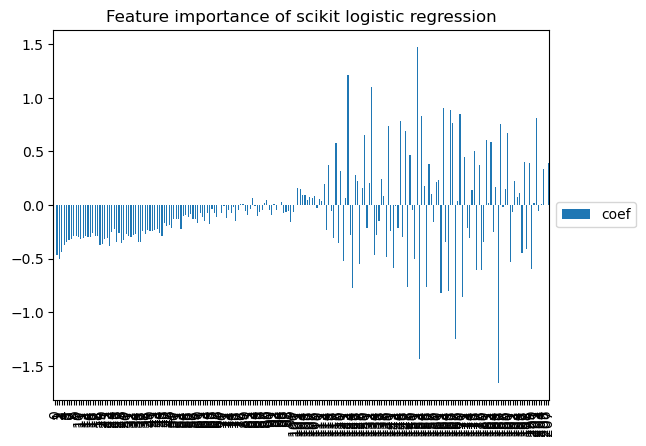

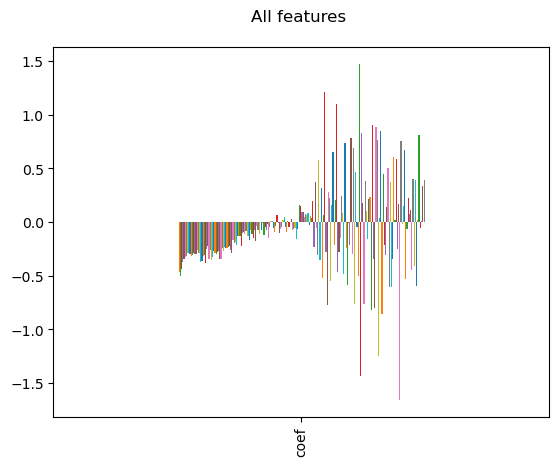

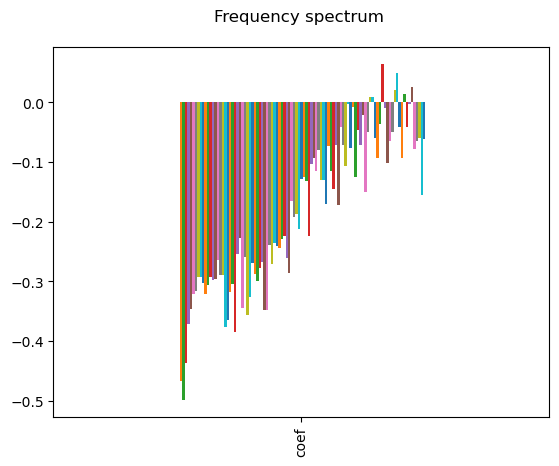

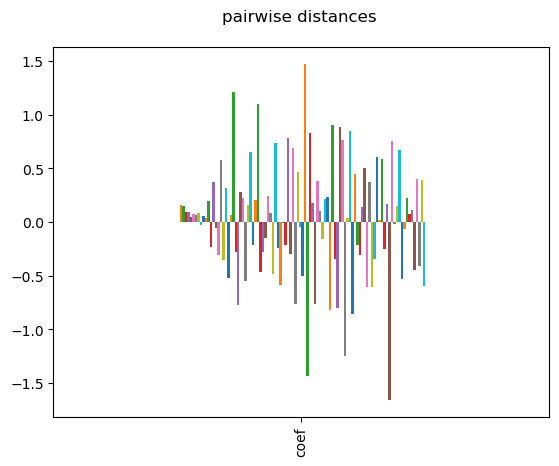

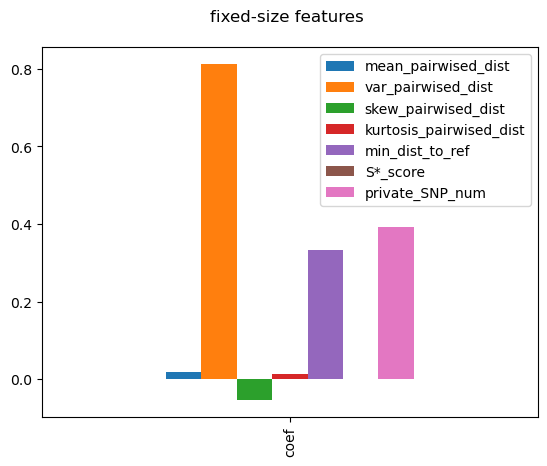

In [18]:
scikit_logistic_importance(example_file, drop_labels, use_abs_log=False)

[0.0,
 -2.5249781261312343,
 -2.933580920713002,
 -2.6499224585897116,
 -2.3210541771602498,
 -2.1533589885497664,
 -2.006613704011396,
 -1.9458696706330907,
 -1.7757118968634755,
 -1.7824895766696667,
 -1.816827130215342,
 -1.8836729868767335,
 -1.8255280190982763,
 -1.6852519365082261,
 -1.679964399262329,
 -1.7072395456843843,
 -1.5089044107891803,
 -1.6482891952574972,
 -1.6384641993893179,
 -2.091577393039573,
 -2.0212790856891796,
 -1.7642190993241469,
 -1.6926752479184166,
 -2.1253200520992555,
 -1.3706165782584405,
 -1.2264480260603483,
 -1.861361997027959,
 -1.4101355407142484,
 -1.9091181356431124,
 -1.702892031357436,
 -1.5007557577420618,
 -1.58098823778263,
 -1.5946394522093783,
 -1.50282060632037,
 -1.4393301130156269,
 -1.913799793015584,
 -1.8424281329638132,
 -1.2961674882756822,
 -1.4602577947790938,
 -1.2720255804615674,
 -1.2703684250916842,
 -1.28453315983088,
 -1.217870537690431,
 -1.1591733922381706,
 -1.4249071718883675,
 -1.4997559456233658,
 -0.863358264994026

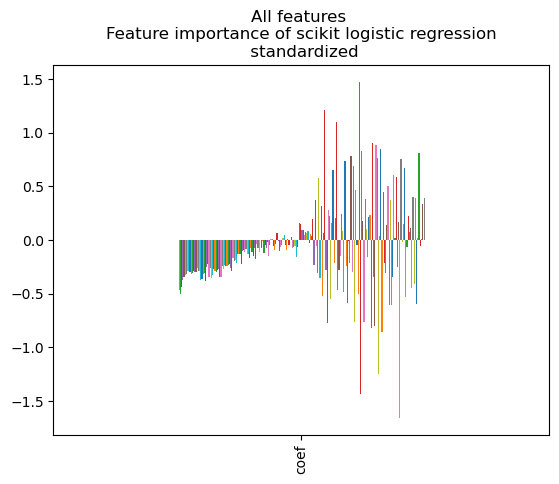

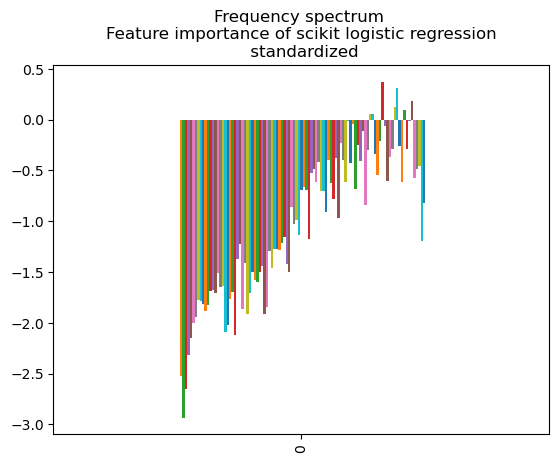

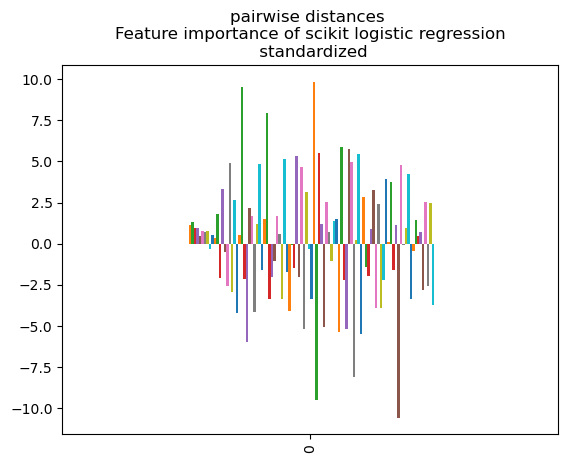

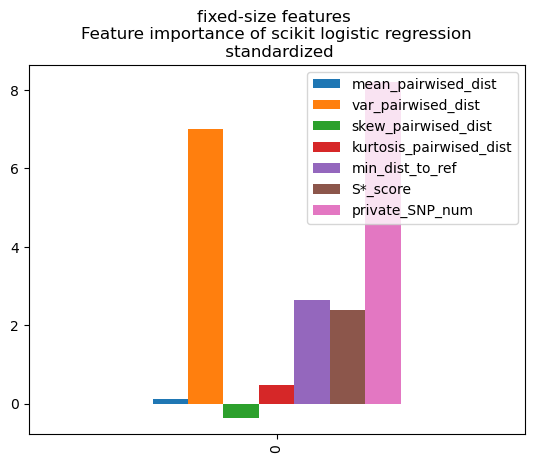

In [19]:
scikit_logistic_importance_standardized(example_file, stats_file, use_abs_log=False)

C:\Users\josef\AppData\Local\Temp\ipykernel_36900\4142328062.py:42: RuntimeWarning: divide by zero encountered in log
  new_coefficients = np.log(np.abs(new_coefficients))


array([       -inf,  0.9262324 ,  1.07622383,  0.97453038,  0.84202147,
        0.76702894,  0.69644858,  0.66570901,  0.57420141,  0.57801103,
        0.59709164,  0.63322359,  0.60186927,  0.52191507,  0.5187726 ,
        0.53487777,  0.41138383,  0.4997379 ,  0.49375934,  0.73791851,
        0.70373052,  0.56770816,  0.52631026,  0.7539224 ,  0.3152607 ,
        0.20412221,  0.62130848,  0.34368583,  0.64664143,  0.532328  ,
        0.40596882,  0.45805012,  0.46664766,  0.40734375,  0.36417781,
        0.64909069,  0.61108434,  0.25941182,  0.37861299,  0.24061058,
        0.23930696,  0.25039535,  0.19710387,  0.14770716,  0.35410667,
        0.40530239, -0.14692554,  0.02906778, -0.0153121 ,  0.12588417,
       -0.35984099, -0.41624036, -0.36995907,  0.16061924, -0.64442224,
       -0.7171149 , -0.49253881, -0.8832336 , -0.35764134, -0.34748647,
       -0.09736425, -0.91948055, -0.47820069, -0.24952209, -0.96537557,
       -0.0287313 , -1.45939517, -0.93156341, -0.49401589, -4.20

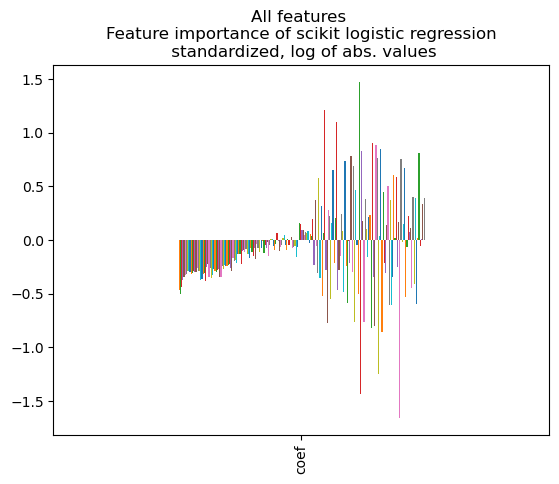

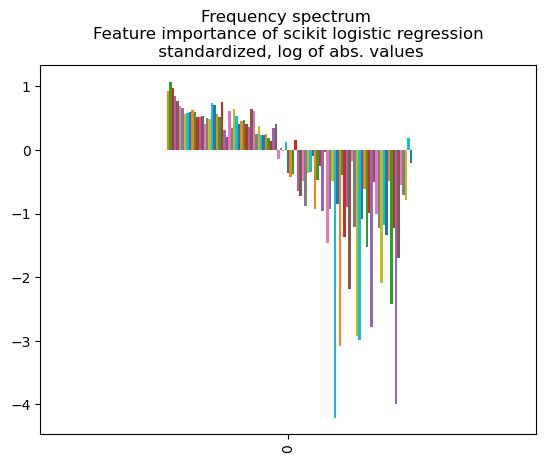

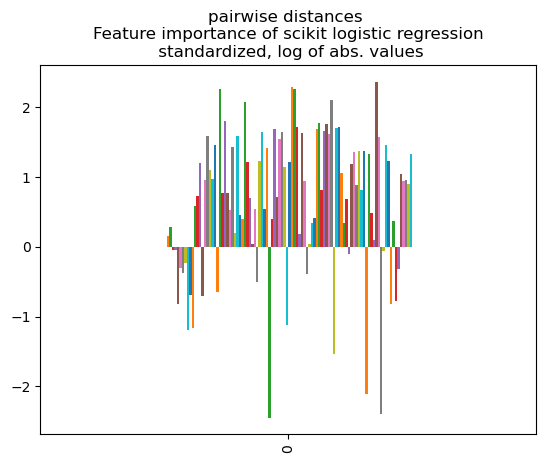

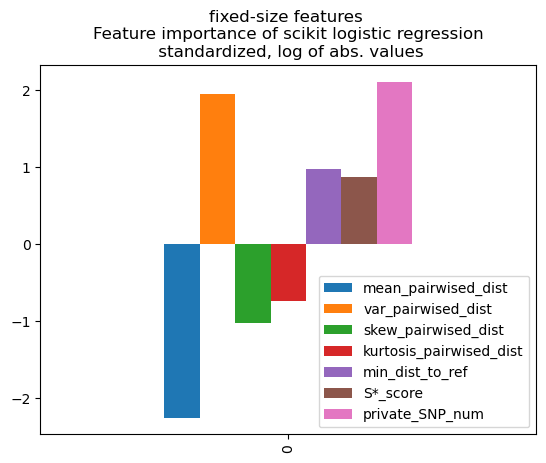

In [20]:
scikit_logistic_importance_standardized(example_file, stats_file, use_abs_log=True)